First let's import all the needed library functions:

In [1]:
from os import makedirs
from PIL import Image
from shutil import rmtree, copyfile
from matplotlib.pyplot import figure, subplot, imshow, imread, plot, text
from os import listdir
from numpy import random
from torchvision import models, transforms
from torch.autograd import Variable
from torch import no_grad, load
import torch.nn as nn

Now I define the functions needed to retrieve some sample data from the dataset, and print them:

In [2]:
def fetch_demo_samples(demo_samples_num):
    """Copy random images from cropped dataset to a new
    folder for demo.

    Args:
        demo_samples_num (int): number of demo samples to fetch.

    Returns:
        list of strings: list of dog names from related folders
    """
    if "cropped_demo_samples" in listdir("../data"):
        rmtree("../data/cropped_demo_samples")
    makedirs("../data/cropped_demo_samples")
    breed_list = listdir("../data/annotation")
    dogs = []
    for i in range(demo_samples_num):
        breed = random.choice(breed_list)
        dog = random.choice(listdir("../data/annotation/" + breed))
        copyfile(
            src="../data/cropped_images/" + breed + "/" + dog + ".jpg",
            dst="../data/cropped_demo_samples/" + dog + ".jpg",
        )
        dogs.append(dog)
    return dogs


def plot_chosen_sample(demo_samples, demo_samples_num):
    figure(figsize=(10, demo_samples_num * 6))
    for i, dog_sample in enumerate(demo_samples):
        subplot(len(demo_samples) * 100 + 11 + i)
        img = imread("../data/cropped_demo_samples/" + dog_sample + ".jpg")
        imshow(img)

I chose to to use 6 images as samples for this demo. Here are the chosen random images:

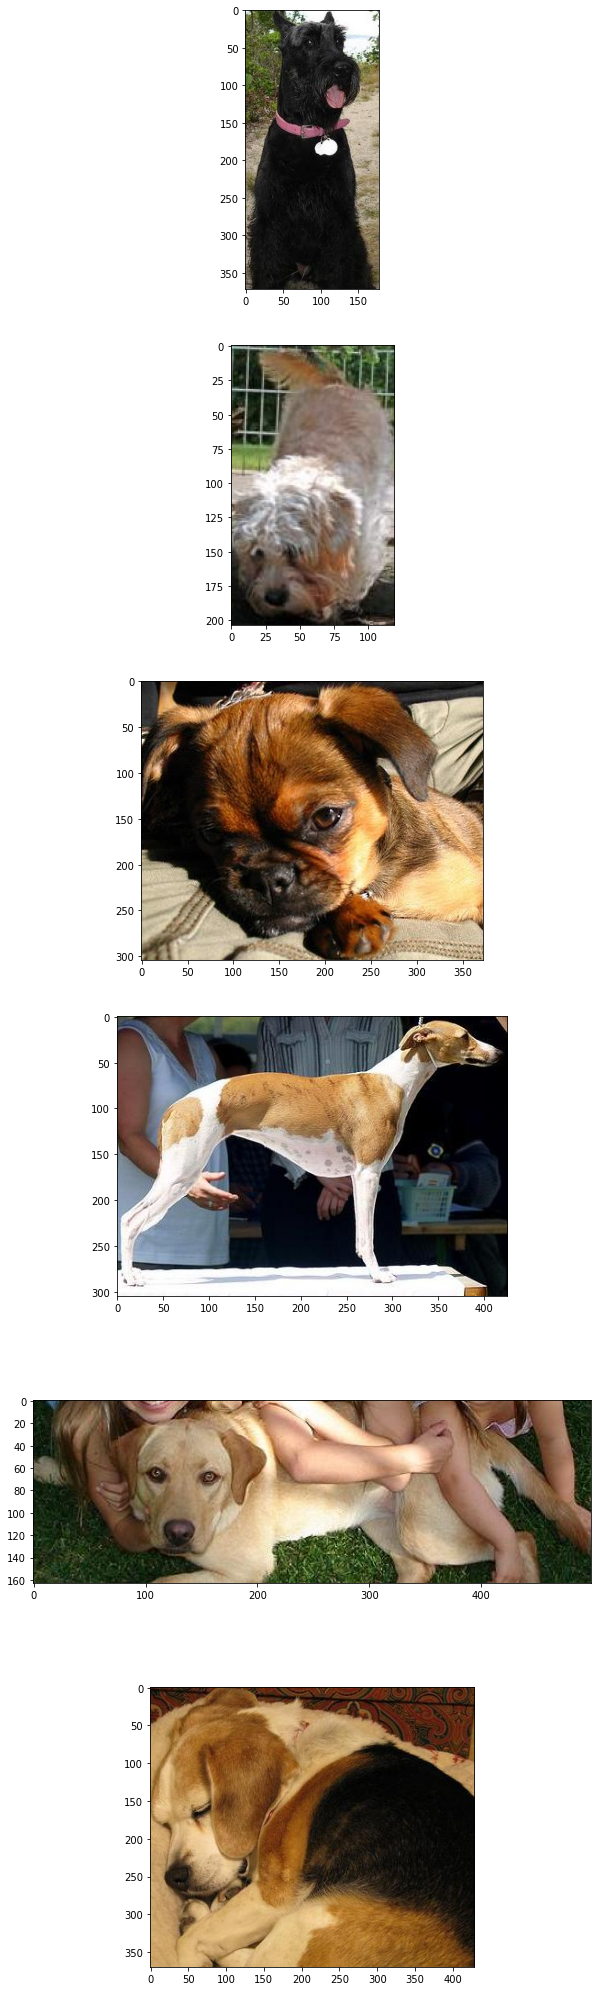

In [3]:
demo_samples_num = 6
demo_samples = fetch_demo_samples(demo_samples_num)
plot_chosen_sample(demo_samples, demo_samples_num)

Now I define all the functions which will transform the image into the format needed by the model, load the model from a checkpoint file, classify tensors/images one by one and evaluate the results:

In [4]:
def convert_image_to_3dtensor(dog):
    """Transform the sample image into a tensor and then decompress it,
    adding a dimension on the 0-axis to be processed by the trained classifier.

    Args:
        dog (string): dog name

    Returns:
        pytorch.tensor: 3d tensor representation of image
    """
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(Image.open("../data/cropped_demo_samples/" + dog)).unsqueeze(0)

import traceback

def load_model_from_checkpoint(path = "best_dog_classifier_model.pt"):
    """This function loads and returns the stored model

    Returns:
        Inception3 object: the trained inception model
    """
    model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
    n_classes = 120
    n_inputs = model.fc.in_features
    model.aux_logits = False # Add
    model.fc = nn.Sequential(
        nn.Linear(n_inputs, 1024),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(1024, n_classes),
        nn.LogSoftmax(dim=1),
    )
    try:
        torch_checkpoint = load(path)
        model.load_state_dict(torch_checkpoint["model_state_dict"])
        model.idx_to_class = torch_checkpoint["idx_to_class"]
    except:
        print(traceback.format_exc())
        return None
    return model


def classify(model, img):
    """Classifies the given tensor image using the given model

    Args:
        model (Inception3 object): trained inception_v3 model
        img (pytorch.tensor): image represented as tensor

    Returns:
        string: classification result
    """
    model.eval()
    with no_grad():
        output = model(img)
        _, pred = output.unsqueeze(0).topk(1)
        breed = model.idx_to_class[pred[0].item()]
    return breed


def find_breed(code):
    """This function returns the dog to which the code corresponds

    Args:
        code (string): code included in the names of the dogs in the dataset

    Returns:
        string: complete dog name, comprehensive of code and name
    """
    return [dog for dog in listdir("../data/annotation") if code in dog][0]


def plot_classification_results(model, demo_samples_num):
    breed_list = listdir("../data/annotation")
    figure(figsize=(10, demo_samples_num * 6))
    for i, dog in enumerate(listdir("../data/cropped_demo_samples")):
        if dog.endswith(".jpg"):
            try:
                img = convert_image_to_3dtensor(dog)
                predicted_breed = classify(model, img)
                subplot(demo_samples_num * 100 + 11 + i)
                img = imread("../data/cropped_demo_samples/" + dog)
                imshow(img)
                ground_truth_breed = find_breed(dog[:8])
                is_match = predicted_breed == ground_truth_breed
                text(
                    10,
                    15,
                    "Predicted breed: " + predicted_breed,
                    bbox=dict(facecolor="lightgreen" if is_match else "red", alpha=0.85),
                )
                text(
                    10,
                    40,
                    "Actual breed: " + ground_truth_breed,
                    bbox=dict(facecolor="yellow", alpha=0.85),
                )
            except Exception as e:
                print(e)

Finally we can appreciate the results of the model:

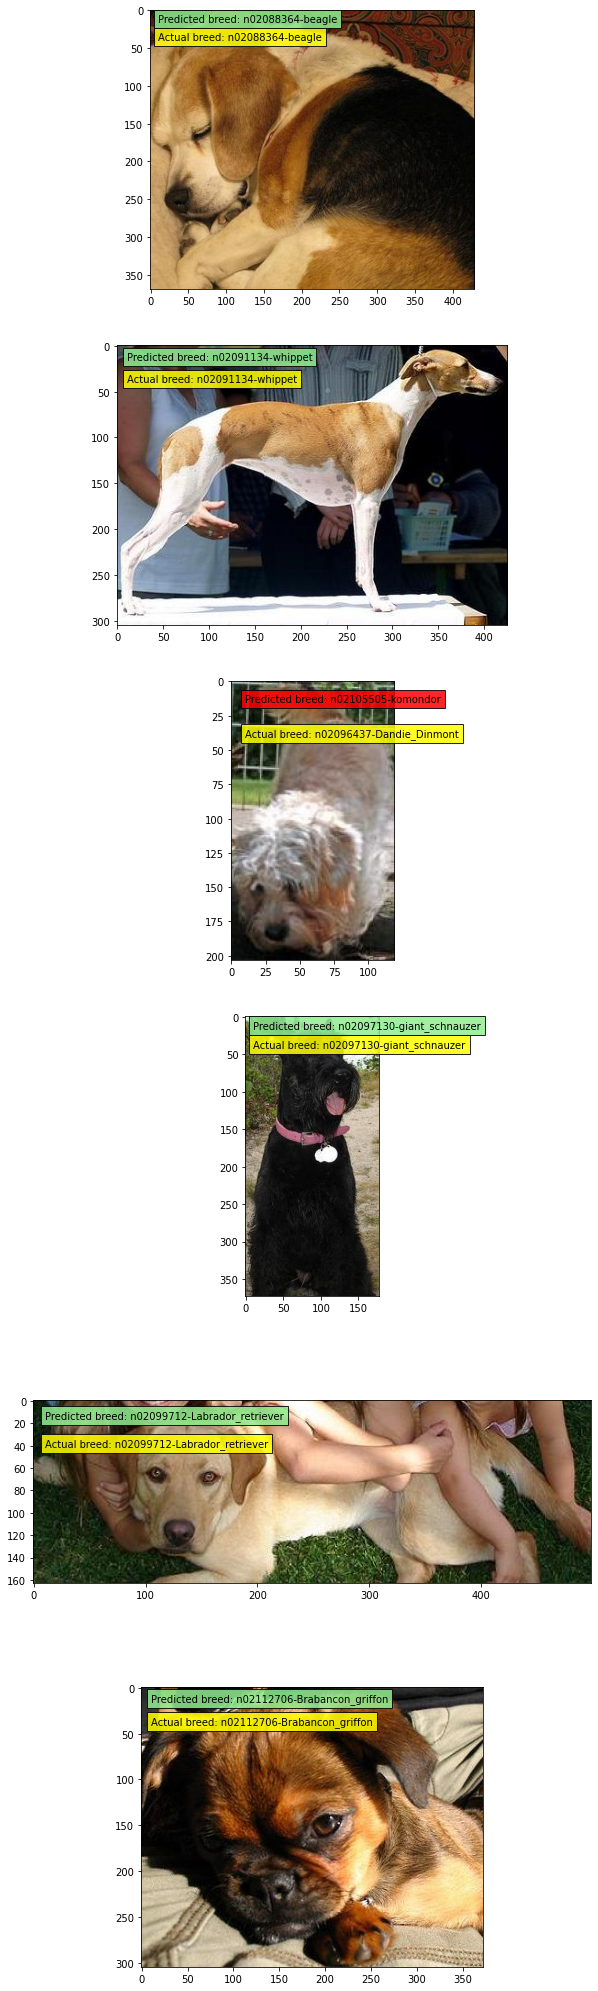

In [5]:
plot_classification_results(
    model=load_model_from_checkpoint(), demo_samples_num=demo_samples_num
)